# Pipeline for prosthesis resizing to fit stump and electrodes

### Import the stump and socket, and create a point cloud

In [1]:
import open3d as o3d
import numpy as np
import copy

# Load the STL files for stump and socket
stump_mesh = o3d.io.read_triangle_mesh("stump.stl")
socket_mesh = o3d.io.read_triangle_mesh("socket.stl")

# Convert the meshes to point clouds for easier handling if necessary
stump_pcd = stump_mesh.sample_points_uniformly(number_of_points=100000)

# 
# Visualize the initial stump and socket
o3d.visualization.draw_geometries([stump_pcd], window_name="Initial Stump and Socket")


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### Try removing the elbow and seeing how much bettter the PCA might be

In [76]:
import open3d as o3d
import numpy as np
import copy


# Create a copy of the mesh
stump_mesh_shorter = copy.deepcopy(stump_mesh)

# Convert vertices and triangles to NumPy arrays
vertices = np.asarray(stump_mesh_shorter.vertices)
triangles = np.asarray(stump_mesh_shorter.triangles)

# Find the maximum Z-coordinate (top of the mesh)
max_y = np.max(vertices[:, 1])

# Filter vertices within 25 cm below the top
valid_vertex_mask = vertices[:, 1] > max_y -0.3
filtered_vertices = vertices[valid_vertex_mask]

# Update triangles to only include valid vertices
valid_indices = np.where(valid_vertex_mask)[0]
index_map = {old_idx: new_idx for new_idx, old_idx in enumerate(valid_indices)}
filtered_triangles = [
    [index_map[v0], index_map[v1], index_map[v2]]
    for v0, v1, v2 in triangles
    if v0 in index_map and v1 in index_map and v2 in index_map
]

# Update the mesh
stump_mesh_shorter.vertices = o3d.utility.Vector3dVector(filtered_vertices)
stump_mesh_shorter.triangles = o3d.utility.Vector3iVector(filtered_triangles)
stump_pcd_shorter = stump_mesh_shorter.sample_points_uniformly(number_of_points=100000)

# Visualize the result
o3d.visualization.draw_geometries([stump_mesh,stump_pcd_shorter], window_name="Filtered Stump Mesh")


### Align stump mesh to y-axis

In [77]:
 
# Create a reference X,Y,Z axis

def create_axes(center = [0,0,0]):
    """
    Creates 3D arrows representing the X, Y, and Z axes.
    
    Parameters:
    - scale: Length of each axis.
    
    Returns:
    - List of Open3D geometries (arrows for X, Y, Z axes).
    """
    arrows = []
    cylinder_height = 0.1
    cone_height = 0.005
    total_size = cylinder_height+cone_height
    arrow_params = {'cylinder_radius': 0.001, 'cone_radius': 0.002, 'cone_height': cone_height, 'cylinder_height': cylinder_height}
    
    # X-axis (red)
    x_axis = o3d.geometry.TriangleMesh.create_arrow(**arrow_params)
    x_axis.paint_uniform_color([1, 0, 0])  # Red
    x_axis.rotate(o3d.geometry.get_rotation_matrix_from_xyz([0, np.pi / 2, 0]))  # Point along X
    x_axis.translate(np.add(center,[total_size/2,0,0]))  # Translate to center
    arrows.append(x_axis)


    # Y-axis (green)
    y_axis = o3d.geometry.TriangleMesh.create_arrow(**arrow_params)
    y_axis.paint_uniform_color([0, 1, 0])  # Green
    y_axis.rotate(o3d.geometry.get_rotation_matrix_from_xyz([-np.pi / 2, 0, 0]))  # Point along X

    y_axis.translate(np.add(center,[0,total_size/2,0]))  # Translate to center
    arrows.append(y_axis)
    
    # Z-axis (blue)
    z_axis = o3d.geometry.TriangleMesh.create_arrow(**arrow_params)
    z_axis.paint_uniform_color([0, 0, 1])  # Blue
    z_axis.rotate(o3d.geometry.get_rotation_matrix_from_xyz([ 0, 0, 0]))  # Point along Z
    z_axis.translate(np.add(center,[0,0,total_size/2]))  # Translate to center
    arrows.append(z_axis)
    
    return arrows

# axes = create_axes()
# o3d.visualization.draw_geometries([*axes], window_name="Axes")


In [78]:
def align_to_y_axis(mesh_input, part_of_mesh_to_align_input = None):
    """
    Align the mesh or align based on another part of the mesh (part_of_mesh_to_align).
    """
    mesh = copy.deepcopy(mesh_input)
    part_of_mesh_to_align = copy.deepcopy(part_of_mesh_to_align_input)  
    if part_of_mesh_to_align:
        # Compute the principal components for the mesh to align to
        align_vertices = np.asarray(part_of_mesh_to_align.vertices)
    else:
        # Compute the principal components for the given mesh
        align_vertices = np.asarray(mesh.vertices)

    # Calculate the center of mass for the alignment mesh
    align_center_of_mass = np.mean(align_vertices, axis=0)
    centered_vertices = align_vertices - align_center_of_mass
    cov = np.cov(centered_vertices.T)  # Covariance matrix
    eigenvalues, eigenvectors = np.linalg.eig(cov)  # Eigen decomposition
    
    
    # Extract the principal axis (based on maximum eigenvalue)
    principal_axis = eigenvectors[:, np.argmax(eigenvalues)]  # Principal axis
    print("Principal Component Axis (To Align To):", principal_axis)

    # This part below is to ensure that the top point stays the top point
    if principal_axis[1] < 0:
        flip_y = True
    else:
        flip_y = False
    # Compute the rotation matrix to align the principal axis with the Y-axis
    y_axis = np.array([0, 1, 0])  # Target y-axis
    v = np.cross(principal_axis, y_axis)  # Cross product for the rotation axis
    s = np.linalg.norm(v)  # Magnitude of the rotation axis
    c = np.dot(principal_axis, y_axis)  # Dot product for the cosine of the angle
    if s != 0:
        v_skew = np.array([
            [0, -v[2], v[1]],
            [v[2], 0, -v[0]],
            [-v[1], v[0], 0]
        ])  # Skew-symmetric matrix for cross product
        rotation_matrix = np.eye(3) + v_skew + np.dot(v_skew, v_skew) * ((1 - c) / (s ** 2))
    else:
        rotation_matrix = np.eye(3)  # No rotation needed if already aligned

    # Apply the rotation matrix to the mesh (not the part_of_mesh_to_align)
    mesh.rotate(rotation_matrix, center=align_center_of_mass)

    # Check if the new principal axis is flipped and needs correction
    mesh_vertices = np.asarray(mesh.vertices)
    mesh_center_of_mass = np.mean(mesh_vertices, axis=0)
    centered_mesh_vertices = mesh_vertices - mesh_center_of_mass
    mesh_cov = np.cov(centered_mesh_vertices.T)
    mesh_eigenvalues, mesh_eigenvectors = np.linalg.eig(mesh_cov)
    new_principal_axis = mesh_eigenvectors[:, np.argmax(mesh_eigenvalues)]
    # print("New Principal Component Axis:", new_principal_axis)

    if flip_y:
        flip_rotation = np.array([
            [1,  0,  0],
            [0, -1,  0],
            [0,  0,  1]
        ])  # 180-degree rotation about the Y-axis
        mesh.rotate(flip_rotation, center=mesh_center_of_mass)

    mesh.translate((-align_center_of_mass[0], 0, -align_center_of_mass[2]))

    # Print final alignment for verification
    print("New Principal Component Axis:", new_principal_axis)

    return mesh

# Align both the stump and socket to the Y-axis
stump_mesh_aligned_WITH_BELOW_ELBOW = align_to_y_axis(stump_mesh)
stump_mesh_aligned = align_to_y_axis(stump_mesh,stump_mesh_shorter)
stump_pcd_aligned = stump_mesh_aligned.sample_points_uniformly(number_of_points=100000)

visualization_no_elbow = copy.deepcopy(stump_mesh_aligned)
visualization_no_elbow_pcd = visualization_no_elbow.sample_points_uniformly(number_of_points=100000)

visualization_with_elbow = copy.deepcopy(stump_mesh_aligned_WITH_BELOW_ELBOW)
visualization_with_elbow_pcd = visualization_with_elbow.sample_points_uniformly(number_of_points=100000)


axes = create_axes(np.mean(np.asarray(stump_mesh_aligned.vertices),axis=0))

o3d.visualization.draw_geometries([visualization_with_elbow, *axes], window_name="Aligned Mesh with Axes BELOW ELBOW")
o3d.visualization.draw_geometries([visualization_no_elbow, *axes], window_name="Aligned Mesh with Axes WITHOUT ELBOW")




Principal Component Axis (To Align To): [0.15331892 0.88519368 0.4392328 ]
New Principal Component Axis: [3.81728591e-15 1.00000000e+00 1.35555549e-14]
Principal Component Axis (To Align To): [0.24283567 0.8852094  0.39678098]
New Principal Component Axis: [ 0.08888256 -0.9950923  -0.04348805]


### Create the cylinder that will act as the socket

In [79]:
import open3d as o3d
import numpy as np

material_thickness = 0.007 # Thickness of the socket
def create_cylinder_aligned_to_stump(stump_mesh, height=0.05):  # Height in meters (20 cm)
    # Extract vertices from the stump mesh
    vertices = np.asarray(stump_mesh.vertices)
    
    top_y = np.max(vertices[:,1])
    vertices_top_of_stump = vertices[vertices[:, 1] > top_y - 0.1]
    # Compute the bounding box to find the largest width in the X-Z plane
    x_coords = vertices_top_of_stump[:, 0]
    z_coords = vertices_top_of_stump[:, 2]
    largest_width = np.sqrt((x_coords.max() - x_coords.min())**2 + (z_coords.max() - z_coords.min())**2)
    radius = largest_width / 2  # Radius is half the diameter
    
    # Create a cylinder aligned to the Y-axis
    cylinder = o3d.geometry.TriangleMesh.create_cylinder(radius=radius+material_thickness, height=height, resolution = 1000)
    cylinder = align_to_y_axis(cylinder)
    cylinder.compute_vertex_normals()  # Ensure normals are computed for visualization
    
    # Translate the cylinder to align its base at the origin
    cylinder.translate((0, -height/2,0 ))
    
    return cylinder

# Create a cylinder with the specified properties
socket_mesh = create_cylinder_aligned_to_stump(stump_mesh_aligned, height=0.4)
socket_pcd = socket_mesh.sample_points_uniformly(number_of_points = 3000)

# Visualize the aligned stump and the cylinder
o3d.visualization.draw_geometries([*axes, stump_pcd_aligned,socket_pcd], window_name="Aligned Stump and Cylinder")


Principal Component Axis (To Align To): [-6.97326255e-18  1.66533454e-16 -1.00000000e+00]
New Principal Component Axis: [-1.02274517e-18  1.00000000e+00 -3.27844923e-16]


### Create random electrode positions (until william can provide us with actual ones)

In [175]:
import random as rand

desired_depth = -0.1 #This is the amount we need the stump to be in the socket

stump_pcd_aligned = stump_mesh_aligned.sample_points_uniformly(number_of_points=100000)

stump_points = np.array(stump_pcd_aligned.points)
electrode_positions = []
maximum_y_position = np.max(stump_points[:,1])
stump_points = stump_points[stump_points[:,1] > maximum_y_position + desired_depth+ 0.005]

print(maximum_y_position)
while True: #select 3 random points on the stump:

    electrode_position_example = stump_points[rand.randint(0,len(stump_points)-1)]
    electrode_positions.append(electrode_position_example)
    if len(electrode_positions) >= 6:
        break

electrode_positions_pcd = o3d.geometry.PointCloud()
electrode_positions_pcd.points = o3d.utility.Vector3dVector(electrode_positions)

o3d.visualization.draw_geometries([electrode_positions_pcd, stump_mesh_aligned], window_name="Initial Stump and Socket")




0.6705431087992493
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 


### Compute the centroids of the points, and place them all on top of each other. We also assume the electrodes are centered with respect to the stump mesh, so all the transformations to the stump also happen to the electrode positions

In [176]:
import copy

# Compute centroids
stump_center = stump_pcd_aligned.get_center()
socket_center = socket_pcd.get_center()


# Create deep copies of the original meshes for centered versions
centered_stump_mesh = copy.deepcopy(stump_mesh_aligned)
centered_socket_mesh = copy.deepcopy(socket_mesh)

# Create deep copies of the original meshes for centered versions
centered_stump_pcd = copy.deepcopy(stump_pcd_aligned)
centered_socket_pcd = copy.deepcopy(socket_pcd)
centered_electrode_positions_pcd = copy.deepcopy(electrode_positions_pcd)
centered_electrode_positions = copy.deepcopy(electrode_positions)


# Translate the copied meshes to center them
centered_stump_mesh.translate(-stump_center)
centered_socket_mesh.translate(-socket_center)

centered_stump_pcd.translate(-stump_center)
centered_socket_pcd.translate(-socket_center)
centered_electrode_positions_pcd.translate(-stump_center)

for point_index in range(len(centered_electrode_positions)):
    centered_electrode_positions[point_index]-=stump_center


# o3d.visualization.draw_geometries([centered_stump_pcd, centered_socket_pcd], window_name="Centered Stump and Socket")
o3d.visualization.draw_geometries([centered_stump_mesh, centered_electrode_positions_pcd, centered_socket_pcd], window_name="Centered Stump and Socket")


### Translate the stump and electrodes until you have a desired position you need

In [177]:
desired_depth = -0.1 #This is the amount we need the stump to be in the socket

# Find the Y-coordinate of the stump tip (lowest point in Y)
socket_bottom_y = np.min(np.asarray(centered_socket_pcd.points)[:, 1])
stump_bottom_y = np.min(np.asarray(centered_stump_pcd.points)[:, 1])
stump_top_y = np.max(np.asarray(centered_stump_pcd.points)[:, 1])
# print (socket_bottom_y, stump_bottom_y, stump_top_y)

# Calculate required translation along the Z-axis
current_difference_y = socket_bottom_y - stump_top_y
stump_translation_y = desired_depth-current_difference_y

translated_and_centered_stump_pcd = copy.deepcopy(centered_stump_pcd)
translated_and_centered_stump_mesh = copy.deepcopy(centered_stump_mesh)
translated_and_centered_electrode_positions_pcd = copy.deepcopy(centered_electrode_positions_pcd)
translated_and_centered_electrode_positions = copy.deepcopy(centered_electrode_positions)

# Translate the stump along Z-axis
translated_and_centered_stump_pcd.translate([0,  -stump_translation_y, 0])
translated_and_centered_stump_mesh.translate([0,  -stump_translation_y, 0])  # Translate original mesh as well
for point_index in range(len(translated_and_centered_electrode_positions)):
    translated_and_centered_electrode_positions[point_index][1]-=stump_translation_y
    
# Create new point cloud for electrode positions
translated_and_centered_electrode_positions_pcd = o3d.geometry.PointCloud()
translated_and_centered_electrode_positions_pcd.points = o3d.utility.Vector3dVector(translated_and_centered_electrode_positions)

# Visualize the positioned stump within the socket
o3d.visualization.draw_geometries([translated_and_centered_stump_mesh, centered_socket_pcd], window_name="Positioned Stump in Socket")
# o3d.visualization.draw_geometries([translated_and_centered_stump_pcd, centered_stump_pcd], window_name="Positioned Stump in Socket")
# o3d.visualization.draw_geometries([translated_and_centered_stump_mesh, centered_socket_mesh], window_name="Positioned Stump in Socket")
# o3d.visualization.draw_geometries([translated_and_centered_stump_mesh, translated_and_centered_electrode_positions_pcd], window_name="Positioned Stump in Socket")


### Scale the stump, but leave the electrode positions as is for now. 



In [178]:
# Calculate center for scaling
# Here, we must calculate the maximum diameter, and scale until we scale by a certain factor
scaling_factor = 1.1 
scaling_distance = 0.01
scaled_vertices = []

scaled_stump_mesh = copy.deepcopy(translated_and_centered_stump_mesh)
stump_new_center = translated_and_centered_stump_pcd.get_center()

# Convert stump vertices to NumPy array for manipulation
stump_vertices = copy.deepcopy(np.asarray(scaled_stump_mesh.vertices))

# Scale non-electrode points outward from the center
for point in stump_vertices:
    direction = point - stump_new_center
    if np.linalg.norm(direction) > 0:
        unit_direction = direction / np.linalg.norm(direction)
        scaled_point = point + unit_direction * scaling_distance
    else:
        scaled_point = point
    scaled_vertices.append(scaled_point)
# Update stump mesh with scaled vertices for inner socket surface

stump_bottom_y = np.min(np.asarray(translated_and_centered_stump_pcd.points)[:, 1])
stump_top_y = np.max(np.asarray(centered_stump_pcd.points)[:, 1])
scaled_stump_mesh.vertices = o3d.utility.Vector3dVector(scaled_vertices)
scaled_stump_pcd = scaled_stump_mesh.sample_points_uniformly(number_of_points=3000)

# Visualize the scaled stump
o3d.visualization.draw_geometries([scaled_stump_pcd, translated_and_centered_stump_mesh, translated_and_centered_electrode_positions_pcd], window_name="Scaled Stump for Inner Socket Surface")


### Now, we want to scale the electrodes in the normal direction to the stump. So not out from the center, but rather the normal of the stump itself. 

We might run into issues here when we consider the possible peaks and valleys of the stump

In [210]:
import numpy as np
import open3d as o3d
from sklearn.neighbors import NearestNeighbors
offset_distance = 0.009  # Adjust distance as needed, (user-defined parameter)

# Function to calculate normals and translate electrodes along the normal direction
def calculate_normals(mesh, electrode_points, neighbors=20):
    normals = []
    mesh_points = np.unique(np.asarray(mesh.vertices), axis = 0) #TODO: Re-look into this, we have more points than we have unique points for some reason
    nbrs = NearestNeighbors(n_neighbors=neighbors).fit(mesh_points)
    mesh_center = mesh.get_center()
    for point in electrode_points:
        _, indices = nbrs.kneighbors([point])

        # Compute normal as average cross-product of nearest neighbors
        v1 = mesh_points[indices[0][1]] - point
        v2 = mesh_points[indices[0][2]] - point
        normal = np.cross(v1, v2)
        
        if np.linalg.norm(normal)   != 0:
            normal /= np.linalg.norm(normal)  # Normalize the vector
    
        # If normal is inwards into the stump, then that means the new point is closer to the stump center, so we must take that into account
        # when we are calculating it. We need the electrode to move always OUTWARDS from the center!

        # Check if the normal is pointing inwards (toward the stump center)
        direction_to_center = mesh_center - point
        if np.dot(normal, direction_to_center) > 0:
            # If dot product is positive, the normal is pointing inward, so flip it
            normal = -normal
    
        normals.append(normal)
    return np.array(normals)


# Calculate normals at each electrode
normals = calculate_normals(translated_and_centered_stump_mesh, translated_and_centered_electrode_positions)

# Scale normals to create translated electrodes
scaled_electrode_positions = translated_and_centered_electrode_positions + normals * offset_distance

# Convert electrode positions to Open3D PointClouds for visualization
scaled_electrodes_pcd = o3d.geometry.PointCloud()
scaled_electrodes_pcd.points = o3d.utility.Vector3dVector(scaled_electrode_positions)


# UNCOMMENT THESE LINES ONLY FOR VISUALIZATION OF THE NORMALS!!!
# Create lines representing the normals
line_points = []
line_indices = []

for i, (start, normal) in enumerate(zip(translated_and_centered_electrode_positions, normals)):
    end = start + normal * offset_distance  # End point of the normal vector line
    line_points.append(start)
    line_points.append(end)
    line_indices.append([2 * i, 2 * i + 1])

# Convert line points and indices to Open3D LineSet for visualization
line_points_o3d = o3d.utility.Vector3dVector(line_points)
line_indices_o3d = o3d.utility.Vector2iVector(line_indices)
normal_lines = o3d.geometry.LineSet(points=line_points_o3d, lines=line_indices_o3d)
normal_lines.colors = o3d.utility.Vector3dVector([[1, 0, 0] for _ in range(len(line_indices))])  # Red color for normals

# Visualize the stump mesh, original electrode positions, translated electrode positions, and normal lines
o3d.visualization.draw_geometries(
    [scaled_stump_pcd,translated_and_centered_stump_mesh, translated_and_centered_electrode_positions_pcd, scaled_electrodes_pcd, normal_lines],
    window_name="Electrode Normals Visualization"
)


### Subtract electrodes from the socket.


In [211]:
electrode_mesh_template = o3d.io.read_triangle_mesh("electrode.stl")
electrode_mesh_template_center = electrode_mesh_template.get_center()
electrode_mesh_template.translate(-electrode_mesh_template_center)

# Scale the mesh to convert from millimeters to meters
scaling_factor = 1 / 1000  # Millimeters to meters
electrode_mesh_template.scale(scaling_factor, center=electrode_mesh_template.get_center())
electrode_mesh_template_aligned = copy.deepcopy(electrode_mesh_template)

electrode_mesh_template = align_to_y_axis(electrode_mesh_template)
electrode_mesh_template_aligned.rotate([[1,0,0],[0,1,0],[0,0,-1]])
electrode_mesh_template = align_to_y_axis(electrode_mesh_template)
electrode_mesh_template.rotate([[1,0,0],[0,0,1],[0,-1,0]])

o3d.visualization.draw_geometries([*axes,electrode_mesh_template] ,
                                  window_name="Aligned Electrodes on Socket")

Principal Component Axis (To Align To): [ 5.1359801e-17 -1.0000000e+00  0.0000000e+00]
New Principal Component Axis: [-2.33201258e-16 -1.00000000e+00  0.00000000e+00]
Principal Component Axis (To Align To): [ 2.33201258e-16 -1.00000000e+00  0.00000000e+00]
New Principal Component Axis: [ 5.60793502e-16 -1.00000000e+00  2.60208521e-18]


In [213]:
import open3d as o3d
import numpy as np

# Load the custom electrode shape from the STL file
electrode_mesh_template = o3d.io.read_triangle_mesh("electrode.stl")
electrode_mesh_template = align_to_y_axis(electrode_mesh_template)
electrode_mesh_template.rotate([[1,0,0],[0,0,1],[0,-1,0]])

# Scale the mesh to convert from millimeters to meters
scaling_factor = 1 / 1000  # Millimeters to meters
electrode_mesh_template.scale(scaling_factor, center=electrode_mesh_template.get_center())
# Function to align and place the electrode mesh at each scaled electrode position
def create_aligned_electrode_mesh(position, normal):

    # Create a copy of the electrode mesh template
    electrode_mesh = copy.deepcopy(electrode_mesh_template)
    
    # Align the electrode along the normal direction
    # Calculate the rotation matrix to align the y-axis with the normal vector
    y_axis = np.array([0, 1, 0])  # Assume the electrode points along y-axis by default
    rotation_axis = np.cross(y_axis, normal)
    rotation_angle = np.arccos(np.dot(y_axis, normal))
    
    if np.linalg.norm(rotation_axis) > 0:  # Avoid division by zero if no rotation is needed
        rotation_axis /= np.linalg.norm(rotation_axis)
        rotation_matrix = o3d.geometry.get_rotation_matrix_from_axis_angle(rotation_axis * rotation_angle)
        electrode_mesh.rotate(rotation_matrix, center=(0, 0, 0))

    # Translate the aligned electrode to the specified position
    electrode_mesh.translate(position)

    return electrode_mesh

# Create the aligned electrode meshes at each scaled electrode position
aligned_electrodes = []
for position, normal in zip(scaled_electrode_positions, normals):
    aligned_electrode = create_aligned_electrode_mesh(position, normal)
    aligned_electrodes.append(aligned_electrode)

# Visualize the stump mesh, socket mesh, and aligned electrodes
o3d.visualization.draw_geometries([translated_and_centered_stump_mesh, normal_lines, scaled_stump_pcd] + aligned_electrodes,
                                  window_name="Aligned Electrodes on Socket")


Principal Component Axis (To Align To): [ 1.49191949e-16 -1.00000000e+00 -8.67361738e-19]
New Principal Component Axis: [ 1.54764234e-16  1.00000000e+00 -4.07584786e-17]


In [214]:
import trimesh

def o3d_to_trimesh(o3d_mesh):
    """Convert an Open3D TriangleMesh to a Trimesh mesh."""
    vertices = np.asarray(o3d_mesh.vertices)
    faces = np.asarray(o3d_mesh.triangles)
    return trimesh.Trimesh(vertices=vertices, faces=faces)

# Convert the socket, stump, and electrodes meshes
socket_trimesh = o3d_to_trimesh(centered_socket_mesh)
stump_trimesh = o3d_to_trimesh(scaled_stump_mesh)

# Combine electrode meshes into a single Trimesh object
electrode_trimeshes = [o3d_to_trimesh(electrode) for electrode in aligned_electrodes]
combined_stump_and_electrodes_trimesh = trimesh.util.concatenate(electrode_trimeshes + [stump_trimesh])


# Combine all electrode meshes into a single compound object
combined_electrodes = trimesh.util.concatenate(electrode_trimeshes)

# Check if the combined electrodes are valid for Boolean operations
if not combined_stump_and_electrodes_trimesh.is_volume:
    print("Combined electrodes are not watertight. Attempting to fix...")
    combined_stump_and_electrodes_trimesh.fill_holes()  # Fill small holes if any
    print(combined_stump_and_electrodes_trimesh)
    combined_stump_and_electrodes_trimesh.remove_unreferenced_vertices()

# Perform subtraction in one go
try:
    socket_with_holes = socket_trimesh.difference(combined_stump_and_electrodes_trimesh)
    print("Subtraction successful!")
except ValueError as e:
    print(f"Subtraction failed: {e}")

# # Subtract the combined stump and electrodes from the socket
# socket_with_holes = copy.deepcopy(socket_trimesh)
# i=0
# print(socket_trimesh)
# print(combined_stump_and_electrodes_trimesh)
# socket_with_holes = socket_trimesh.difference([socket_trimesh, combined_stump_and_electrodes_trimesh])

# for electrode in electrode_trimeshes:
#     print(i)
#     print(electrode)
#     print(socket_with_holes)
#     socket_with_holes = socket_trimesh.difference([electrode,socket_with_holes])
#     i+=1

Combined electrodes are not watertight. Attempting to fix...
<trimesh.Trimesh(vertices.shape=(10510, 3), faces.shape=(20980, 3))>
Subtraction successful!


In [222]:

def trimesh_to_o3d(tri_mesh):
    """Convert a Trimesh mesh to an Open3D TriangleMesh."""
    mesh = o3d.geometry.TriangleMesh()
    mesh.vertices = o3d.utility.Vector3dVector(tri_mesh.vertices)
    mesh.triangles = o3d.utility.Vector3iVector(tri_mesh.faces)
    return mesh

# Convert the final socket with holes back to Open3D
final_socket_mesh = trimesh_to_o3d(socket_with_holes)
final_socket_pcd = final_socket_mesh.sample_points_uniformly(number_of_points=20000)

#Not quite sure whether we need to keep this line
# combined_stump_and_electrodes = stump_trimesh.union(combined_stump_and_electrodes_trimesh)

final_stump_mesh = trimesh_to_o3d(combined_stump_and_electrodes_trimesh)

o3d.visualization.draw_geometries([final_socket_pcd] + aligned_electrodes,
                                  window_name="Aligned Electrodes on Socket")


In [225]:
if False:    
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    import numpy as np

    # Extract vertices and faces from the Trimesh mesh
    vertices = socket_with_holes.vertices
    faces = socket_with_holes.faces

    # Plot with depth-based color
    fig = plt.figure(figsize=(12, 12))  # Larger figure size
    ax = fig.add_subplot(111, projection='3d')

    # Create color mapping based on the Z-coordinate (depth) of each vertex
    depth_colors = vertices[:, 2]  # Use Z-coordinate for color

    # Plot the mesh with color based on depth
    poly = ax.plot_trisurf(vertices[:, 0], vertices[:, 1], vertices[:, 2], triangles=faces,
                        cmap='viridis', edgecolor='k', alpha=0.8, antialiased=True)
    poly.set_array(depth_colors)

    # Ensure equal scaling across all axes
    ax.set_box_aspect([1, 1, 100/30])

    # Flip the view upside down with a rotated perspective
    ax.view_init(elev=180+45, azim=45)

    # Add color bar for depth
    fig.colorbar(poly, label='Depth (Z-coordinate)', shrink=0.6, aspect=10)
    ax.set_title("Socket with Depth-Based Coloring (Flipped)")

    plt.show()


C:\Users\karim\AppData\Local\Temp\ipykernel_25924\1566574318.py:39: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(mappable, label='Depth (Z-coordinate)', shrink=0.6, aspect=10)


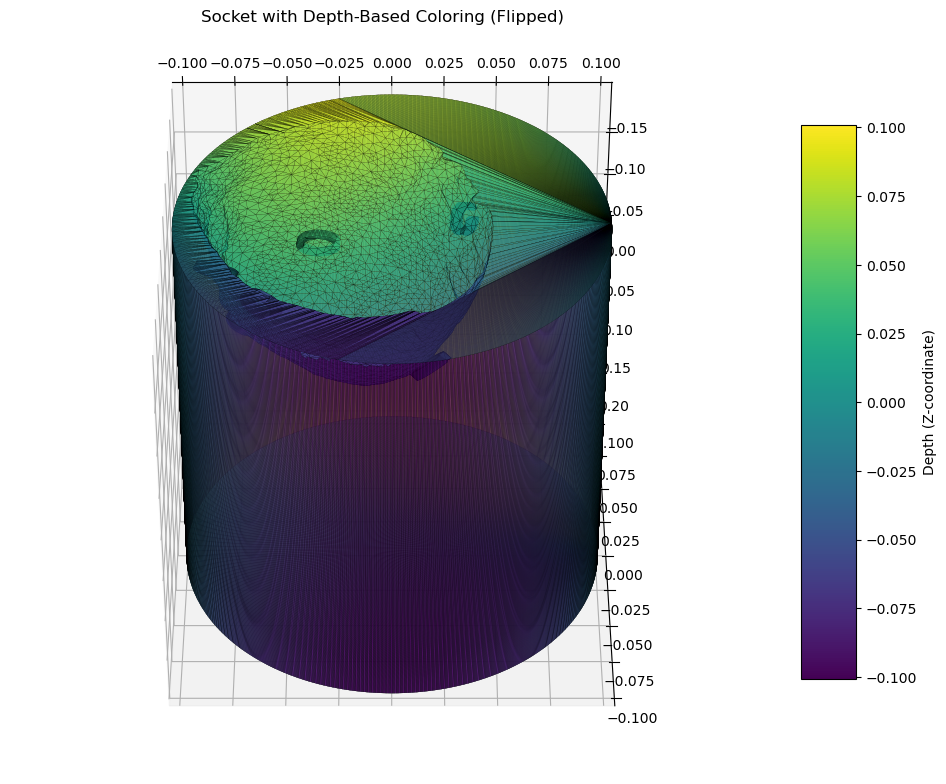

In [226]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np

# Extract vertices and faces from the Trimesh mesh
vertices = socket_with_holes.vertices
faces = socket_with_holes.faces

# Set up figure and 3D axes
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

# Normalize depth (Z-coordinate) for colormap
depth_colors = vertices[:, 2]  # Use Z-coordinate for depth
norm = plt.Normalize(depth_colors.min(), depth_colors.max())
colors = plt.cm.viridis(norm(depth_colors))

# Prepare face colors based on average Z depth of each face
face_colors = []
for face in faces:
    # Calculate average Z-depth for each face
    avg_z = vertices[face, 2].mean()
    face_color = plt.cm.viridis(norm(avg_z))  # Map average Z to colormap
    face_colors.append(face_color)

# Create Poly3DCollection for mesh with depth-based face colors
mesh = Poly3DCollection(vertices[faces], facecolors=face_colors, edgecolor='k', linewidths=0.1, alpha=0.8)
ax.add_collection3d(mesh)

# Set equal scaling across all axes
ax.set_box_aspect([1, 1, 1])

# Flip the view upside down with a rotated perspective
ax.view_init(elev=-50, azim=-90)

# Add color bar for depth
mappable = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
mappable.set_array(depth_colors)
fig.colorbar(mappable, label='Depth (Z-coordinate)', shrink=0.6, aspect=10)
ax.set_title("Socket with Depth-Based Coloring (Flipped)")

# Set axis limits based on vertex range for better visualization
ax.set_xlim(vertices[:, 0].min(), vertices[:, 0].max())
ax.set_ylim(vertices[:, 1].min(), vertices[:, 1].max())
ax.set_zlim(vertices[:, 2].min(), vertices[:, 2].max())

plt.show()
